<a href="https://colab.research.google.com/github/zachrobel/Soccer_Analysis/blob/main/Soccer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Video



In [ ]:
!pip install ultralytics
!pip install roboflow
!pip install supervision

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8x')

results = model.predict('Soccer1.mp4', save=True)
print(results[0])
print('===============================')

for box in results[0].boxes:
  print(box)


100%|██████████| 131M/131M [00:00<00:00, 204MB/s]


FileNotFoundError: Soccer1.mp4 does not exist

# Get Dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Zc10kKvu944d9TXcsnXx")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


KeyboardInterrupt: 

In [ ]:
dataset.location

'/content/football-players-detection-1'

In [ ]:
import shutil

shutil.move('football-players-detection-1/train', 'football-players-detection-1/football-players-detection-1/train')
shutil.move('football-players-detection-1/test', 'football-players-detection-1/football-players-detection-1/test')
shutil.move('football-players-detection-1/valid', 'football-players-detection-1/football-players-detection-1/valid')


'football-players-detection-1/football-players-detection-1/valid'

# Training

In [ ]:
!yolo task=detect mode=train model=yolov5lu.pt data={dataset.location}/data.yaml epochs=100 imgsz=640


100% 102M/102M [00:00<00:00, 322MB/s] 
Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5lu.pt, data=/content/football-players-detection-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

In [ ]:
!cp runs/detect/train4/weights/last.pt drive/MyDrive/Colab Notebooks

cp: target 'Notebooks' is not a directory


# Updated Model Detection

In [ ]:
from ultralytics import YOLO

model = YOLO('best-4.pt')

results = model.predict('Soccer1.mp4', save=True)
print(results[0])
print('===============================')

for box in results[0].boxes:
  print(box)


KeyboardInterrupt: 

# Video Utils


In [ ]:
!pip install opencv-python

In [ ]:
import cv2

def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames

In [ ]:
def save_video(ouput_video_frames,output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 24, (ouput_video_frames[0].shape[1], ouput_video_frames[0].shape[0]))
    for frame in ouput_video_frames:
        out.write(frame)
    out.release()

# BBOX Utils

In [ ]:
import cv2
def get_center_of_bbox(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2),int((y1+y2)/2)
def get_bbox_width(bbox):
    return bbox[2]-bbox[0]
def measure_distance(p1,p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

#  Color Assignment

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
image_path = "stubs/cropped_.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

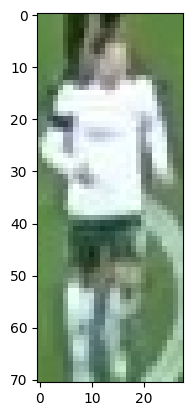

In [ ]:
plt.imshow(image)
plt.show()

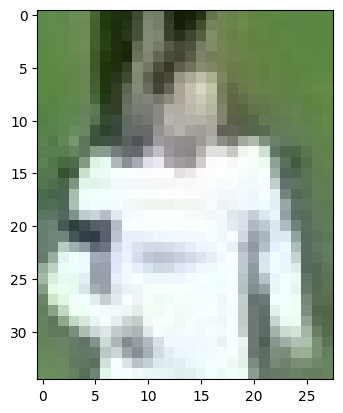

In [ ]:
top_half_image=  image[0: int(image.shape[0]/2), :]
plt.imshow(top_half_image)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


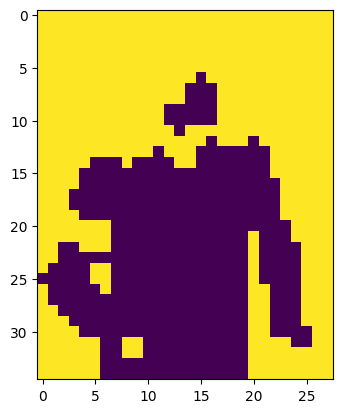

In [ ]:
# Reshape the image into 2d array
image_2d = top_half_image.reshape(-1, 3)

# perform k-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(image_2d)

# get the cluster labels
labels = kmeans.labels_

# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)
plt.show()

In [ ]:
corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
print(non_player_cluster)

1


In [ ]:
player_cluster = 1-non_player_cluster
print(player_cluster)

0


In [ ]:
kmeans.cluster_centers_[player_cluster]

array([226.05084746, 235.26876513, 235.16707022])

# Player Ball Assignment


In [ ]:
class PlayerBallAssigner():
    def __init__(self):
        self.max_player_ball_distance = 70

    def assign_ball_to_player(self,players,ball_bbox):
        ball_position = get_center_of_bbox(ball_bbox)

        miniumum_distance = 99999
        assigned_player=-1

        for player_id, player in players.items():
            player_bbox = player['bbox']

            distance_left = measure_distance((player_bbox[0],player_bbox[-1]),ball_position)
            distance_right = measure_distance((player_bbox[2],player_bbox[-1]),ball_position)
            distance = min(distance_left,distance_right)

            if distance < self.max_player_ball_distance:
                if distance < miniumum_distance:
                    miniumum_distance = distance
                    assigned_player = player_id

        return assigned_player

# Team Assignment

In [ ]:
from sklearn.cluster import KMeans

class TeamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.player_team_dict = {}

    def get_clustering_model(self,image):
        # Reshape the image to 2D array
        image_2d = image.reshape(-1,3)

        # Preform K-means with 2 clusters
        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=1)
        kmeans.fit(image_2d)

        return kmeans

    def get_player_color(self,frame,bbox):
        image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

        top_half_image = image[0:int(image.shape[0]/2),:]

        # Get Clustering model
        kmeans = self.get_clustering_model(top_half_image)

        # Get the cluster labels forr each pixel
        labels = kmeans.labels_

        # Reshape the labels to the image shape
        clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

        # Get the player cluster
        corner_clusters = [clustered_image[0,0],clustered_image[0,-1],clustered_image[-1,0],clustered_image[-1,-1]]
        non_player_cluster = max(set(corner_clusters),key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color


    def assign_team_color(self,frame, player_detections):

        player_colors = []
        for _, player_detection in player_detections.items():
            bbox = player_detection["bbox"]
            player_color =  self.get_player_color(frame,bbox)
            player_colors.append(player_color)

        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=10)
        kmeans.fit(player_colors)

        self.kmeans = kmeans

        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]


    def get_player_team(self,frame,player_bbox,player_id):
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        player_color = self.get_player_color(frame,player_bbox)

        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id+=1

        if player_id ==91:
            team_id=1

        self.player_team_dict[player_id] = team_id

        return team_id

# Tracking

In [ ]:
from ultralytics import YOLO
import supervision as sv
import pickle
import os
import numpy as np
import pandas as pd

class Tracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()

    def interpolate_ball_positions(self,ball_positions):
        ball_positions = [x.get(1,{}).get('bbox',[]) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

        # Interpolate missing values
        df_ball_positions = df_ball_positions.interpolate()
        df_ball_positions = df_ball_positions.bfill()

        ball_positions = [{1: {"bbox":x}} for x in df_ball_positions.to_numpy().tolist()]

        return ball_positions


    def detect_frames(self, frames):
        batch_size=20
        detections = []
        for i in range(0,len(frames),batch_size):
            detections_batch = self.model.predict(frames[i:i+batch_size],conf=0.1)
            detections += detections_batch
        return detections

    def get_object_tracks(self, frames, read_from_stub=False, stub_path=None):

        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path,'rb') as f:
                tracks = pickle.load(f)

        detections = self.detect_frames(frames)

        tracks={
            "players":[],
            "referees":[],
            "ball":[]
        }

        for frame_num, detection in enumerate(detections):
            cls_names = detection.names
            cls_names_inv = {v:k for k,v in cls_names.items()}

            detection_supervision = sv.Detections.from_ultralytics(detection)

            # Convert GoalKeeper to player object
            for object_ind , class_id in enumerate(detection_supervision.class_id):
                if cls_names[class_id] == "goalkeeper":
                    detection_supervision.class_id[object_ind] = cls_names_inv["player"]

            detection_with_tracks = self.tracker.update_with_detections(detection_supervision)

            tracks["players"].append({})
            tracks["referees"].append({})
            tracks["ball"].append({})

            for frame_detection in detection_with_tracks:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]
                track_id = frame_detection[4]

                if cls_id == cls_names_inv['player']:
                    tracks["players"][frame_num][track_id] = {"bbox":bbox}

                if cls_id == cls_names_inv['referee']:
                    tracks["referees"][frame_num][track_id] = {"bbox":bbox}

            for frame_detection in detection_supervision:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]

                if cls_id == cls_names_inv['ball']:
                    tracks["ball"][frame_num][1] = {"bbox":bbox}


        if stub_path is not None:
            with open(stub_path,'wb') as f:
                pickle.dump(tracks,f)

        return tracks

    def draw_ellipse(self,frame,bbox,color,track_id=None):
        y2 = int(bbox[3])
        x_center, _ = get_center_of_bbox(bbox)
        width = get_bbox_width(bbox)

        cv2.ellipse(
            frame,
            center=(x_center,y2),
            axes=(int(width), int(0.35*width)),
            angle=0.0,
            startAngle=-45,
            endAngle=235,
            color = color,
            thickness=2,
            lineType=cv2.LINE_4
        )

        rectangle_width = 40
        rectangle_height=20
        x1_rect = x_center - rectangle_width//2
        x2_rect = x_center + rectangle_width//2
        y1_rect = (y2- rectangle_height//2) +15
        y2_rect = (y2+ rectangle_height//2) +15

        if track_id is not None:
            cv2.rectangle(frame,
                          (int(x1_rect),int(y1_rect) ),
                          (int(x2_rect),int(y2_rect)),
                          color,
                          cv2.FILLED)

            x1_text = x1_rect+12
            if track_id > 99:
                x1_text -=10

            cv2.putText(
                frame,
                f"{track_id}",
                (int(x1_text),int(y1_rect+15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0,0,0),
                2
            )

        return frame

    def draw_traingle(self,frame,bbox,color):
        y= int(bbox[1])
        x,_ = get_center_of_bbox(bbox)

        triangle_points = np.array([
            [x,y],
            [x-10,y-20],
            [x+10,y-20],
        ])
        cv2.drawContours(frame, [triangle_points],0,color, cv2.FILLED)
        cv2.drawContours(frame, [triangle_points],0,(0,0,0), 2)

        return frame
    def draw_team_ball_control(self,frame,frame_num,team_ball_control):
        # Draw a semi-transparent rectaggle
        overlay = frame.copy()
        cv2.rectangle(overlay, (1350, 850), (1900,970), (255,255,255), -1 )
        alpha = 0.4
        cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

        team_ball_control_till_frame = team_ball_control[:frame_num+1]
        # Get the number of time each team had ball control
        team_1_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==1].shape[0]
        team_2_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==2].shape[0]
        team_1 = team_1_num_frames/(team_1_num_frames+team_2_num_frames)
        team_2 = team_2_num_frames/(team_1_num_frames+team_2_num_frames)

        cv2.putText(frame, f"Team 1 Ball Control: {team_1*100:.2f}%",(1400,900), cv2.TIMES_NEW_ROMAN, 1, (0,0,0), 3)
        cv2.putText(frame, f"Team 2 Ball Control: {team_2*100:.2f}%",(1400,950), cv2.TIMES_NEW_ROMAN, 1, (0,0,0), 3)

        return frame

    def draw_annotations(self, video_frames, tracks, team_ball_control):
        output_video_frames = []
        for frame_num, frame in enumerate(video_frames):
            frame = frame.copy()

            if frame_num < len(tracks["players"]):  # Check if frame_num is within bounds
                player_dict = tracks["players"][frame_num]
                ball_dict = tracks["ball"][frame_num]
                referee_dict = tracks["referees"][frame_num]

                for track_id, player in player_dict.items():
                    color = player.get('team_color',(0,0,225))
                    frame = self.draw_ellipse(frame, player['bbox'], color, track_id)

                    if player.get('has_ball',False):
                        frame = self.draw_traingle(frame, player["bbox"],(0,0,255))
                for _, referee in referee_dict. items ():
                    frame = self. draw_ellipse(frame, referee["bbox"], (0,255, 255))
                for track_id, ball in ball_dict.items():
                    frame = self.draw_traingle(frame, ball["bbox"],(0,255,0))

                # Draw Team Ball Control
                frame = self.draw_team_ball_control(frame, frame_num, team_ball_control)

            output_video_frames.append(frame)

        return output_video_frames


# Main

In [ ]:
def main():
    video_frames = read_video('Soccer1.mp4')
    tracker = Tracker('best-4.pt')
    tracks = tracker.get_object_tracks(video_frames,
                                        read_from_stub=True,
                                       stub_path='stubs/track_stubs.pkl')
    for track_id, player in tracks['players'][0].items():
        bbox = player['bbox']
        frame = video_frames[0]
        # crop bbox from frame
        cropped_image = frame[int(bbox[1]):int (bbox[3]), int(bbox[0]):int(bbox[2])]
        # save the cropped image
        cv2.imwrite('stubs/cropped_image.jpg', cropped_image)

    tracks["ball"] = tracker.interpolate_ball_positions(tracks["ball"])

    team_assigner = TeamAssigner()
    team_assigner.assign_team_color(video_frames[0],
                                    tracks['players'][0])

    for frame_num, player_track in enumerate(tracks['players']):
        for player_id, track in player_track.items():
            team = team_assigner.get_player_team(video_frames[frame_num],
                                                track['bbox'],
                                                player_id)
            tracks['players'][frame_num][player_id]['team'] = team
            tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]

    player_assigner =PlayerBallAssigner()
    team_ball_control= []
    for frame_num, player_track in enumerate(tracks['players']):
        ball_bbox = tracks['ball'][frame_num][1]['bbox']
        assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

        if assigned_player != -1:
            tracks['players'][frame_num][assigned_player]['has_ball'] = True
            team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
        else:
            team_ball_control.append(team_ball_control[-1])
    team_ball_control= np.array(team_ball_control)

    output_video_frames = tracker.draw_annotations(video_frames, tracks, team_ball_control)



    save_video(output_video_frames,'ouput_3.avi')

In [ ]:
main()


0: 384x640 1 goalkeeper, 19 players, 2 referees, 2119.1ms
1: 384x640 1 goalkeeper, 19 players, 2 referees, 2119.1ms
2: 384x640 1 ball, 1 goalkeeper, 18 players, 2 referees, 2119.1ms
3: 384x640 1 ball, 1 goalkeeper, 18 players, 2 referees, 2119.1ms
4: 384x640 1 ball, 2 goalkeepers, 19 players, 2 referees, 2119.1ms
5: 384x640 1 ball, 1 goalkeeper, 20 players, 2 referees, 2119.1ms
6: 384x640 1 ball, 1 goalkeeper, 21 players, 1 referee, 2119.1ms
7: 384x640 1 ball, 1 goalkeeper, 21 players, 1 referee, 2119.1ms
8: 384x640 1 goalkeeper, 20 players, 1 referee, 2119.1ms
9: 384x640 1 goalkeeper, 20 players, 2 referees, 2119.1ms
10: 384x640 1 ball, 1 goalkeeper, 20 players, 2 referees, 2119.1ms
11: 384x640 1 goalkeeper, 19 players, 1 referee, 2119.1ms
12: 384x640 1 goalkeeper, 20 players, 1 referee, 2119.1ms
13: 384x640 1 goalkeeper, 21 players, 1 referee, 2119.1ms
14: 384x640 1 goalkeeper, 20 players, 2 referees, 2119.1ms
15: 384x640 1 goalkeeper, 19 players, 2 referees, 2119.1ms
16: 384x640 1 